# Assignment 6

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 72

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [26]:
df = pd.read_csv('suicide-rates.csv')

print(f'Number of datapoints: {len(df)} \nNumber of features: {len(df.columns)}\n')

df.head()

Number of datapoints: 27820 
Number of features: 12



,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [3]:
# Get a count of the nulls here
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


### Early look at correlations

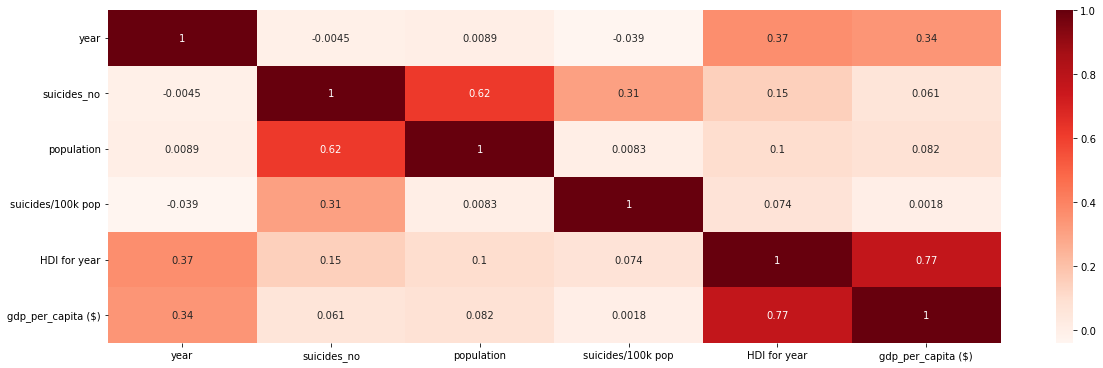

In [5]:
plt.figure(figsize=(20,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Reds')
plt.show()

The most highly correlated (**before pre-processing**) features are HDI and GDP per capita as well as population and suicide numbers (which is obvious). 

In [12]:
suicide_rate_mean = df['suicides/100k pop'].mean()
suicide_rate_std = df['suicides/100k pop'].std()

print(f'Suicide Rate mean: {suicide_rate_mean:.3f} and std: {suicide_rate_std:.3f}')

suicide_rate_mean_plus_std = suicide_rate_mean + suicide_rate_std/2

print(f'Suicide rate mean + std: {suicide_rate_mean_plus_std:.3f}')
df['low/high suicide rate'] = [1 if num >= suicide_rate_mean_plus_std else 0 for num in df['suicides/100k pop']]

df['low/high suicide rate'].value_counts()

Suicide Rate mean: 12.816 and std: 18.962
Suicide rate mean + std: 22.297


0    22786
1     5034
Name: low/high suicide rate, dtype: int64

# Data Preprocessing

In [15]:
df.describe()

,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_per_capita ($),low/high suicide rate
count,27820.000000,27820.000000,2.782000e+04,27820.000000,8364.000000,27820.000000,27820.000000
mean,2001.258375,242.574407,1.844794e+06,12.816097,0.776601,16866.464414,0.180949
std,8.469055,902.047917,3.911779e+06,18.961511,0.093367,18887.576472,0.384983
min,1985.000000,0.000000,2.780000e+02,0.000000,0.483000,251.000000,0.000000
25%,1995.000000,3.000000,9.749850e+04,0.920000,0.713000,3447.000000,0.000000
50%,2002.000000,25.000000,4.301500e+05,5.990000,0.779000,9372.000000,0.000000
75%,2008.000000,131.000000,1.486143e+06,16.620000,0.855000,24874.000000,0.000000
max,2016.000000,22338.000000,4.380521e+07,224.970000,0.944000,126352.000000,1.000000


In [16]:
df.isnull().sum()

country                      0
year                         0
sex                          0
age                          0
suicides_no                  0
population                   0
suicides/100k pop            0
country-year                 0
HDI for year             19456
 gdp_for_year ($)            0
gdp_per_capita ($)           0
generation                   0
low/high suicide rate        0
dtype: int64

There are a ton of nulls in the HDI column, so I will drop that.

In [17]:
df = df.drop(['HDI for year'], axis = 1)
df.shape

(27820, 12)

In [18]:
df.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', ' gdp_for_year ($) ',
       'gdp_per_capita ($)', 'generation', 'low/high suicide rate'],
      dtype='object')

In [19]:
df.isna().any(axis=0)

country                  False
year                     False
sex                      False
age                      False
suicides_no              False
population               False
suicides/100k pop        False
country-year             False
 gdp_for_year ($)        False
gdp_per_capita ($)       False
generation               False
low/high suicide rate    False
dtype: bool

The dataset contains no rows with nulls, which is good.

In [20]:
# Since we determined country does not seem to be relevant, we will drop that as well.
# Also, if we kept this, we would have to one-hot encode it and then we would add a ton of columns
# to our dataset
df = df.drop('country', axis=1)

# We will also drop country-year since that is derived and year is more important
df = df.drop('country-year', axis=1)

# We will also drop gdp_for_year as it is a total measure and is not relevant since we have per capita
df = df.drop(' gdp_for_year ($) ', axis=1)

# We will drop population for the same reason as gdp_for_year and it has a low correlation
df = df.drop('population', axis=1)

# We will drop suicide_no for the same reason as population, even though it has a high correlation. Mistake?
df = df.drop('suicides_no', axis=1)

In [21]:
# Sanity check
df.head()

,year,sex,age,suicides/100k pop,gdp_per_capita ($),generation,low/high suicide rate
0,1987,male,15-24 years,6.71,796,Generation X,0
1,1987,male,35-54 years,5.19,796,Silent,0
2,1987,female,15-24 years,4.83,796,Generation X,0
3,1987,male,75+ years,4.59,796,G.I. Generation,0
4,1987,male,25-34 years,3.28,796,Boomers,0


We now need to encode the nominal data, of which we have sex, age, and generation. Generation and age, however, are ordinal values so those have to be encoded differently.

In [22]:
df['age'].unique()

array(['15-24 years', '35-54 years', '75+ years', '25-34 years',
       '55-74 years', '5-14 years'], dtype=object)

In [23]:
df['generation'].unique()

array(['Generation X', 'Silent', 'G.I. Generation', 'Boomers',
       'Millenials', 'Generation Z'], dtype=object)

In [24]:
age_order = ['5-14 years', '15-24 years', '25-34 years', '35-54 years', '55-74 years', '75+ years']
generation_order = ['G.I. Generation', 'Silent', 'Boomers', 'Generation X', 'Millenials', 'Generation Z']

df['age'] = OrdinalEncoder(categories=[age_order]).fit_transform(df[['age']])
df['generation'] = OrdinalEncoder(categories=[generation_order]).fit_transform(df[['generation']])

# Since this is not ordinal, we need to one-hot encode
df = pd.get_dummies(df, columns=['sex'])

df.head()

,year,age,suicides/100k pop,gdp_per_capita ($),generation,low/high suicide rate,sex_female,sex_male
0,1987,1.0,6.71,796,3.0,0,0,1
1,1987,3.0,5.19,796,1.0,0,0,1
2,1987,1.0,4.83,796,3.0,0,1,0
3,1987,5.0,4.59,796,0.0,0,0,1
4,1987,2.0,3.28,796,2.0,0,0,1
